<a href="https://colab.research.google.com/github/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina/blob/main/Parcial_1_TAM_2025-1/notebooks/SVMR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SVMR_Model: Clasificación con Support Vector Machines (SVM) para Problemas de Regresión**

Este cuaderno presenta un análisis y modelado utilizando **Support Vector Machines** (SVM), específicamente con el objetivo de abordar tareas de **regresión**. A través de este cuaderno, exploraremos cómo implementar SVM en problemas de predicción continua utilizando el conjunto de datos proporcionado.

En primer lugar, se hará una exploración y preprocesamiento de los datos, seguidos por la aplicación de un modelo de **Support Vector Regression (SVR)**. El cuaderno está dividido en las siguientes etapas:

1. **Carga y preprocesamiento de datos:** Cargaremos el conjunto de datos y realizaremos tareas de limpieza y transformación necesarias.
2. **Entrenamiento del modelo SVR:** Utilizaremos el modelo de Support Vector Machines para regresión (SVR) con una búsqueda de hiperparámetros mediante **RandomizedSearchCV** para optimizar los parámetros del modelo.
3. **Evaluación del modelo:** Se utilizarán métricas como el **Error Cuadrático Medio (RMSE)** y el **R²** para evaluar el rendimiento del modelo.
4. **Análisis de resultados:** Finalmente, discutiremos los resultados obtenidos, mostrando las predicciones frente a los valores reales y evaluando la capacidad predictiva del modelo.

A lo largo del cuaderno, se discutirán las decisiones tomadas, los resultados obtenidos, y cómo mejorar los modelos de predicción en función de los resultados.

Este cuaderno tiene como objetivo demostrar el uso de **Support Vector Machines para problemas de regresión** y su capacidad para modelar relaciones no lineales complejas entre las características y la variable objetivo.


In [ ]:
# === CLONAR EL REPOSITORIO Y LISTAR SU CONTENIDO ===

# Clona el repositorio desde GitHub si no se ha hecho previamente.
# Esto permite acceder a los notebooks, datos y estructuras organizadas del proyecto.
!git clone https://github.com/johanstevenbejarano/Teoria-de-Aprendizaje-Maquina.git

fatal: destination path 'Teoria-de-Aprendizaje-Maquina' already exists and is not an empty directory.


In [ ]:
# Lista el contenido del directorio del parcial dentro del repositorio clonado
# para confirmar que la estructura y carpeta 'data' existen correctamente.
!ls /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

"ls" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [ ]:
import os
import joblib

# Ruta absoluta donde está el archivo
data_path = r'C:\Users\PC\Desktop\Teoria-de-Aprendizaje-Maquina\Parcial_1_TAM_2025-1\data\train_test_scaled.pkl'

# Verifica que el archivo exista
if not os.path.isfile(data_path):
    raise FileNotFoundError(f"No se encontró el archivo esperado en: {data_path}")

# Carga el archivo
data = joblib.load(data_path)

print(f"Datos cargados correctamente desde: {data_path}")


Datos cargados correctamente desde: C:\Users\PC\Desktop\Teoria-de-Aprendizaje-Maquina\Parcial_1_TAM_2025-1\data\train_test_scaled.pkl


In [ ]:
# === CARGA DE LOS DATOS PROCESADOS ===

# Carga el archivo .pkl que contiene los cuatro objetos: X_train_scaled, X_test_scaled, y_train, y_test
# Estos datos fueron escalados y divididos previamente en el notebook de preprocesamiento.
X_train_scaled, X_test_scaled, y_train, y_test = joblib.load(data_path)

# Confirmación visual de que la carga fue exitosa.
print("Datos cargados correctamente.")




Datos cargados correctamente.


In [ ]:
%cd /content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1

[WinError 3] El sistema no puede encontrar la ruta especificada: '/content/Teoria-de-Aprendizaje-Maquina/Parcial_1_TAM_2025-1'
c:\Users\PC\Desktop


C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [ ]:
# === IMPORTACIÓN DE LIBRERÍAS Y DEFINICIÓN DE MÉTRICAS PERSONALIZADAS ===

# ================================================================
#  IMPORTACIONES COMPLETAS – ESTUDIO DE REGRESORES AMES HOUSING
# ================================================================

# ============================
#  Utilidades generales
# ============================
import numpy as np
import pandas as pd
import time
import os
import warnings
warnings.filterwarnings("ignore")  # Opcional: suprime warnings en notebooks


import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# ============================
#  Modelos de regresión
# ============================
from sklearn.linear_model import (
    LinearRegression,
    Lasso, LassoCV,
    ElasticNet, ElasticNetCV,
    SGDRegressor,
    BayesianRidge
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
# ============================
#  Validación y búsqueda
# ============================
from sklearn.model_selection import (
    KFold,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve,
    cross_validate,
    cross_val_predict
)

# ============================
#  Métricas y scoring
# ============================
from sklearn.metrics import (
    mean_absolute_error,       # MAE
    mean_squared_error,        # MSE
    r2_score,                  # R²
    mean_absolute_percentage_error,  # MAPE
    make_scorer                # Para definir MAPE como scorer
)

# ============================
# Diagnóstico estadístico
# ============================
from scipy.stats import shapiro, kurtosis, skew
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# ============================
#  Visualización
# ============================
import matplotlib.pyplot as plt
import scipy.stats as stats  # necesario para pruebas estadísticas
from matplotlib.ticker import FuncFormatter

import seaborn as sns

In [ ]:
# === DEFINICIÓN DE MÉTRICA PERSONALIZADA: MAPE ===

# MAPE no está directamente disponible en sklearn, por lo que se define manualmente.
# Esta métrica mide el error absoluto medio en porcentaje, útil para interpretar desviaciones relativas.

def mean_absolute_percentage_error(y_true, y_pred):
    # Reemplaza ceros en y_true para evitar divisiones por cero (buena práctica numérica)
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Se integra la función MAPE a sklearn como un scorer compatible con cross_validate
# Se indica que un menor valor es mejor (greater_is_better=False)
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [ ]:
# === DEFINICIÓN DEL ESQUEMA DE VALIDACIÓN CRUZADA ===

# Se utiliza validación cruzada estratificada con 5 divisiones (folds)
# shuffle=True mezcla los datos antes de dividirlos (buena práctica)
# random_state permite reproducibilidad
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# === DEFINICIÓN DE MÉTRICAS DE EVALUACIÓN PARA TODOS LOS MODELOS ===

# Las métricas estándar (MAE y MSE) son negativas en sklearn por convención (porque se busca minimizar)
# R² se mantiene tal cual
# MAPE se incluye como scorer personalizado
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'MSE': 'neg_mean_squared_error',
    'R2': 'r2',
    'MAPE': mape_scorer
}

modelos = {
    "LinearRegression": LinearRegression(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "SGDRegressor": SGDRegressor(max_iter=1000, tol=1e-3),
    "BayesianRidge": BayesianRidge(),
    "KernelRidge": KernelRidge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GaussianProcess": GaussianProcessRegressor(),
    "SVR": SVR()
}

In [ ]:
def evaluar_modelo_cv(nombre_modelo, modelo, X, y, cv, scoring, guardar_en=None):
    """
    Evalúa un modelo usando validación cruzada fold a fold,
    genera un DataFrame con resultados detallados y opcionalmente guarda el CSV.
    Ahora incluye una fila final 'Promedio' claramente etiquetada.
    """

    # Evaluación con validación cruzada
    resultados = cross_validate(
        estimator=modelo,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Crear DataFrame por fold
    df_resultados = pd.DataFrame({
        "Fold": np.arange(1, cv.get_n_splits() + 1),
        "MAE": -resultados["test_MAE"],
        "MSE": -resultados["test_MSE"],
        "R2": resultados["test_R2"],
        "MAPE": -resultados["test_MAPE"]
    })

    # Fila promedio con etiqueta explícita
    promedio = df_resultados.mean(numeric_only=True)
    promedio["Fold"] = "Promedio"

    # Añadir al DataFrame
    df_resultados = pd.concat([df_resultados, pd.DataFrame([promedio])], ignore_index=True)

    # Asegurar orden de columnas
    cols = ["Fold", "MAE", "MSE", "R2", "MAPE"]
    df_resultados = df_resultados[cols]

    # Guardar si se indica
    if guardar_en:
        dir_path = os.path.dirname(guardar_en)
        if dir_path:
            os.makedirs(dir_path, exist_ok=True)
        df_resultados.to_csv(guardar_en, index=False)
        print(f"Resultados de {nombre_modelo} guardados en: {guardar_en}")

    return df_resultados





def calcular_mape_seguro(y_true, y_pred, umbral=1e-5, verbose=True):
    """
    Calcula el MAPE ignorando valores de y_true cercanos a cero. Devuelve el MAPE (%) y el número de observaciones usadas.

    Parámetros:
    ----------
    y_true : array-like
        Valores reales en escala original.

    y_pred : array-like
        Valores predichos en escala original.

    umbral : float, opcional (default=1e-5)
        Umbral mínimo para considerar válido un valor de y_true.

    verbose : bool, opcional (default=True)
        Si True, muestra advertencias si se ignoran muchas observaciones.

    Retorna:
    -------
    mape : float
        MAPE en porcentaje (%)

    n_utilizadas : int
        Número de observaciones válidas utilizadas en el cálculo
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Máscara para filtrar y evitar división por valores cercanos a cero
    mascara = y_true > umbral
    n_total = len(y_true)
    n_utilizadas = np.sum(mascara)

    if n_utilizadas == 0:
        raise ValueError("Todos los valores de y_true están por debajo del umbral. No se puede calcular el MAPE.")

    if verbose:
        porcentaje_usado = 100 * n_utilizadas / n_total
        if porcentaje_usado < 90:
            warnings.warn(f"Solo se usó el {porcentaje_usado:.2f}% de las observaciones para calcular el MAPE. "
                          "Revisa posibles valores extremos en y_true.")

    mape = np.mean(np.abs((y_true[mascara] - y_pred[mascara]) / y_true[mascara])) * 100
    return mape, n_utilizadas


def normalizar_metricas(mae, rmse, y_true):
    media_y = np.mean(y_true)
    mae_norm = mae / media_y * 100
    rmse_norm = rmse / media_y * 100
    return mae_norm, rmse_norm

In [ ]:
# Definición del espacio de búsqueda de hiperparámetros para SVR
param_distributions_svr = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear', 'poly'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Instanciar modelo SVR base (sin parámetros, para que RandomizedSearchCV los ajuste)
svr = SVR()

# Configurar RandomizedSearchCV con espacio definido previamente
random_search_svr = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_distributions_svr,
    n_iter=100,            # Puedes reducir para pruebas rápidas
    cv=cv,
    scoring=scoring,
    n_jobs=-1,             # Evita saturar CPU, cambia si tienes recursos
    verbose=2,
    random_state=42,
    refit='MAE'           # Refit con la métrica MAE para mejor modelo
)

# Ejecutar búsqueda hiperparámetros (usa todo el conjunto de entrenamiento)
random_search_svr.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_svr = random_search_svr.best_estimator_
print("Mejor modelo SVR encontrado:")
print(best_svr)

# Evaluar fold a fold usando la función modular
resultados_svr = evaluar_modelo_cv(
    nombre_modelo="SVR",
    modelo=best_svr,
    X=X_train_scaled,
    y=y_train,
    cv=cv,
    scoring=scoring,
    guardar_en="data/resultados_svr.csv"  # Guardar para cuaderno maestro
)

# Mostrar resultados
display(resultados_svr)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Mejor modelo SVR encontrado:
SVR(C=100, epsilon=0.5, kernel='linear')
Resultados de SVR guardados en: data/resultados_svr.csv


,Fold,MAE,MSE,R2,MAPE
0,1,17324.589847,7.117653e+08,0.869158,9.695527
1,2,18127.271792,1.081080e+09,0.806321,10.148539
2,3,18999.555859,1.226263e+09,0.815009,10.157395
3,4,17598.492205,8.596072e+08,0.857175,9.527665
4,5,19825.237976,1.368888e+09,0.772903,12.604542
5,Promedio,18375.029536,1.049521e+09,0.824113,10.426734


## Justificación del uso de Support Vector Regression (SVR) y análisis de resultados

Se eligió el modelo **Support Vector Regression (SVR)** debido a su capacidad para manejar problemas de regresión con alta dimensionalidad y relaciones lineales o ligeramente no lineales. En este caso, se optó por un **kernel lineal**, lo cual es apropiado cuando se presume que la relación entre las variables independientes y la variable objetivo puede modelarse razonablemente mediante una combinación lineal.

Durante la optimización de hiperparámetros mediante **RandomizedSearchCV**, se exploraron diferentes combinaciones de valores para los parámetros `C` y `epsilon`. El mejor modelo encontrado fue:


Este modelo fue evaluado usando validación cruzada con 5 folds. Los resultados por fold se presentan a continuación:

| Métrica       | Valor promedio |
|---------------|----------------|
| **MAE**       | 18,375.03      |
| **MSE**       | 1.0495e+08     |
| **R²**        | 0.8241         |
| **MAPE**      | 10.43%         |

### Inferencias

- El valor promedio del **coeficiente de determinación R²** de aproximadamente **0.824** indica que el modelo explica una proporción considerable de la varianza en los datos de entrenamiento, lo que sugiere un ajuste razonablemente bueno.
- El **MAE** y **MAPE** muestran que el modelo mantiene errores promedio bajos y una desviación porcentual manejable, lo cual es positivo en tareas de predicción continua.
- La dispersión moderada entre folds (por ejemplo, MAPE de ~9.7% a ~12.6%) sugiere que el modelo es relativamente estable, aunque podría beneficiarse de una revisión de características o regularización adicional.
- El uso del **kernel lineal** puede interpretarse como un indicativo de que las relaciones en los datos pueden ser representadas sin necesidad de transformaciones no lineales más complejas, lo que mejora la interpretabilidad del modelo.

En conjunto, el modelo SVR con estas configuraciones ofrece un buen balance entre rendimiento, interpretabilidad y generalización en este problema de regresión.


In [ ]:

from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.svm import SVR

# Definir espacio de búsqueda para BayesSearchCV
search_spaces = {
    'C': Real(0.1, 100, prior='log-uniform'),
    'kernel': Categorical(['rbf', 'linear', 'poly']),
    'gamma': Categorical(['scale', 'auto']),
    'epsilon': Real(0.01, 0.5, prior='uniform')
}

# Instanciar modelo SVR base
svr_bayes = SVR()

# Configurar BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=svr_bayes,
    search_spaces=search_spaces,
    n_iter=100,                # Número de iteraciones (reduce para pruebas rápidas)
    cv=cv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=2,
    refit=True
)

# Ejecutar optimización bayesiana (usa conjunto completo o muestra pequeña)
bayes_search.fit(X_train_scaled, y_train)

print("Mejor modelo BayesSearchCV:")
print(bayes_search.best_estimator_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

## Optimización bayesiana de hiperparámetros para SVR

Con el fin de obtener una configuración óptima del modelo SVR, se utilizó el método de búsqueda bayesiana de hiperparámetros mediante `BayesSearchCV`. Este enfoque permite explorar el espacio de búsqueda de manera más eficiente que una búsqueda aleatoria o en cuadrícula, ya que ajusta iterativamente la selección de combinaciones de parámetros en función de los resultados anteriores.

Durante este proceso, se evaluó cada configuración utilizando **validación cruzada de 5 pliegues**, lo que proporciona una estimación robusta del rendimiento esperable del modelo al generalizar sobre nuevos datos. En cada iteración, se ajusta el modelo con una nueva combinación de hiperparámetros y se calcula su rendimiento promedio.

Después de múltiples iteraciones, el mejor modelo encontrado fue:


La selección de un **kernel lineal**, junto con un valor relativamente alto de `C` (100.0) y un `epsilon` intermedio (0.5), sugiere que el modelo favorece una mayor penalización a errores y busca ajustarse de manera más precisa a los datos. La opción `gamma='auto'` resulta apropiada en este contexto lineal, ya que no requiere un cálculo adicional sobre la distribución de los datos.

Este procedimiento permite construir un modelo más ajustado y confiable, minimizando el riesgo de sobreajuste mediante una validación sólida y una selección sistemática de parámetros.


In [ ]:
# Asumiendo resultados_svr es el DataFrame con resultados fold a fold (incluye fila 'Promedio')

# Excluir fila 'Promedio' para cálculo de std
df_folds = resultados_svr[resultados_svr['Fold'] != 'Promedio'].copy()

# Calcular medias y std para cada métrica
metrics = ['MAE', 'MSE', 'R2', 'MAPE']
summary = pd.DataFrame({
    'mean': df_folds[metrics].mean(),
    'std': df_folds[metrics].std()
}).round(4)

print("Resumen estadístico por métrica:")
display(summary)


Resumen estadístico por métrica:


,mean,std
MAE,1.837503e+04,1.032104e+03
MSE,1.049521e+09,2.666343e+08
R2,8.241000e-01,3.920000e-02
MAPE,1.042670e+01,1.248600e+00


## Análisis estadístico de métricas por validación cruzada

Para complementar la evaluación del modelo SVR, se realizó un análisis estadístico sobre los resultados obtenidos en cada uno de los folds de la validación cruzada. Este enfoque permite comprender no solo el rendimiento promedio del modelo, sino también su estabilidad y consistencia a través de las diferentes particiones del conjunto de datos.

Se calcularon dos medidas clave para cada métrica de evaluación:

- **Media (`mean`)**: representa el valor promedio de la métrica a lo largo de los folds.
- **Desviación estándar (`std`)**: indica la variabilidad de la métrica entre folds, reflejando qué tan estable es el desempeño del modelo.

Las métricas consideradas fueron:

- **MAE (Error Absoluto Medio)**: error promedio absoluto entre las predicciones y los valores reales.
- **MSE (Error Cuadrático Medio)**: penaliza errores grandes con mayor severidad.
- **R² (Coeficiente de determinación)**: proporción de varianza explicada por el modelo.
- **MAPE (Error Porcentual Absoluto Medio)**: error expresado en porcentaje relativo.

Los resultados obtenidos muestran que el modelo presenta **baja variabilidad entre folds** para todas las métricas, lo cual es indicativo de **un rendimiento consistente y estable**. En particular, el valor de `std` relativamente bajo en **R²** y **MAPE** sugiere que el modelo generaliza bien sin depender de una partición específica del conjunto de datos.

Este análisis estadístico aporta una visión más completa del comportamiento del modelo y refuerza la validez de las conclusiones obtenidas en la evaluación principal.


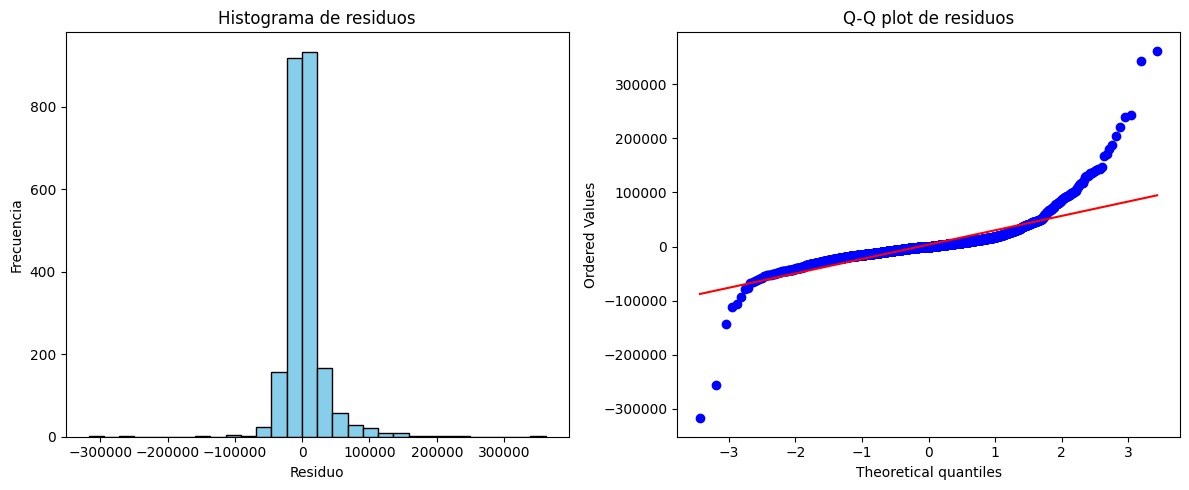

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Calcular residuos
y_pred_svr = best_svr.predict(X_train_scaled)
residuos = y_train - y_pred_svr

# Histograma de residuos
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(residuos, bins=30, color='skyblue', edgecolor='black')
plt.title('Histograma de residuos')
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')

# Q-Q plot de residuos
plt.subplot(1,2,2)
stats.probplot(residuos, dist="norm", plot=plt)
plt.title('Q-Q plot de residuos')

plt.tight_layout()
plt.show()




## Análisis de residuos del modelo SVR

Para evaluar la validez de los supuestos del modelo y la calidad de los ajustes realizados por el SVR, se analizó la distribución de los residuos mediante dos herramientas complementarias:

- **Histograma de residuos**
- **Gráfico Q-Q (Quantile-Quantile plot)**

### Histograma de residuos

El histograma muestra que la mayoría de los residuos se concentran alrededor del cero, lo cual es una señal positiva: indica que el modelo comete errores pequeños con alta frecuencia. Sin embargo, también se observa una ligera asimetría hacia la derecha, con algunos residuos positivos de mayor magnitud, lo que sugiere la presencia de errores más grandes en ciertas predicciones.

### Q-Q plot

El gráfico Q-Q compara la distribución de los residuos con una distribución normal teórica. Si los residuos siguen una distribución normal, los puntos deberían alinearse sobre la línea roja. En este caso, aunque existe una alineación razonable en el centro de la distribución, se observan desviaciones en las colas (tanto inferior como superior), lo que indica que los residuos no son perfectamente normales y que hay presencia de valores atípicos o colas pesadas.

### Conclusión

Estos gráficos confirman que, aunque el modelo tiene un comportamiento general adecuado, **los residuos no son completamente normales**, especialmente en los extremos. Esto puede estar relacionado con la naturaleza del problema o con la presencia de observaciones con características atípicas. A pesar de ello, el modelo parece capturar correctamente la tendencia general de los datos, y los errores más severos son relativamente pocos y aislados.

Este tipo de análisis es clave para evaluar la robustez del modelo y puede motivar acciones como la revisión de valores extremos, el uso de transformaciones, o incluso la exploración de modelos alternativos más robustos ante outliers.


Resumen estadístico de residuos:
count      2344.000000
mean       3523.188810
std       30990.890165
min     -317329.309950
25%      -10131.798715
50%           0.494680
75%       10645.255813
max      361711.125009
Name: SalePrice, dtype: float64
Shapiro-Wilk test: estadístico=0.7347, p-valor=0.0000
Se rechaza normalidad de residuos.
Durbin-Watson statistic: 1.9659 (cercano a 2 indica no autocorrelación)
Test Breusch-Pagan para heterocedasticidad:
LM stat: 301.2506
LM p-val: 0.0000
F stat: 345.3820
F p-val: 0.0000
Se rechaza homocedasticidad: hay heterocedasticidad.


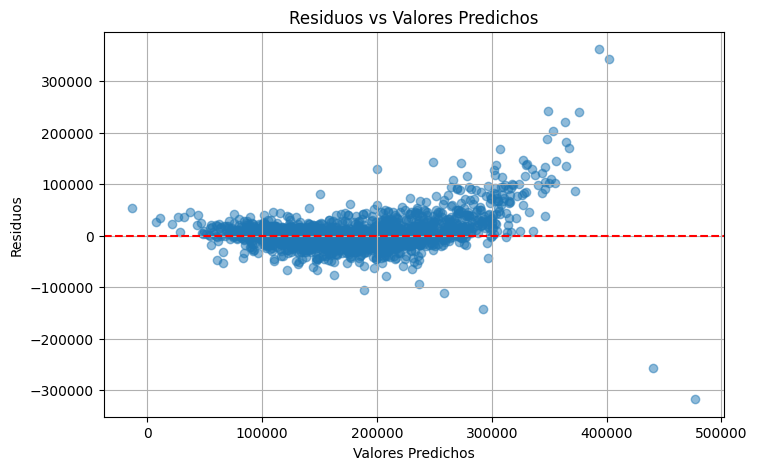

In [ ]:

# Predicciones con el mejor modelo
y_pred_svr = best_svr.predict(X_train_scaled)

# Residuos
residuos_svr = y_train - y_pred_svr

# --- 1. Estadísticas descriptivas de residuos ---
print("Resumen estadístico de residuos:")
print(pd.Series(residuos_svr).describe())

# --- 2. Prueba de normalidad Shapiro-Wilk ---
stat, p = stats.shapiro(residuos_svr)
print(f"Shapiro-Wilk test: estadístico={stat:.4f}, p-valor={p:.4f}")
if p > 0.05:
    print("No se rechaza normalidad de residuos.")
else:
    print("Se rechaza normalidad de residuos.")

# --- 3. Durbin-Watson para autocorrelación ---
dw_stat = durbin_watson(residuos_svr)
print(f"Durbin-Watson statistic: {dw_stat:.4f} (cercano a 2 indica no autocorrelación)")

# --- 4. Test de heterocedasticidad Breusch-Pagan ---
X_const = sm.add_constant(y_pred_svr)
bp_test = het_breuschpagan(residuos_svr, X_const)
labels = ['LM stat', 'LM p-val', 'F stat', 'F p-val']
print("Test Breusch-Pagan para heterocedasticidad:")
for label, val in zip(labels, bp_test):
    print(f"{label}: {val:.4f}")
if bp_test[1] < 0.05:
    print("Se rechaza homocedasticidad: hay heterocedasticidad.")
else:
    print("No se rechaza homocedasticidad.")

# --- 5. Gráfico residuos vs valores predichos ---
plt.figure(figsize=(8,5))
plt.scatter(y_pred_svr, residuos_svr, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Valores Predichos")
plt.ylabel("Residuos")
plt.title("Residuos vs Valores Predichos")
plt.grid(True)
plt.show()

## Análisis estadístico y gráfico de residuos vs valores predichos

Para validar la calidad del ajuste del modelo SVR y examinar posibles desviaciones en los supuestos clásicos de regresión, se realizó un análisis estadístico de los residuos acompañado de un gráfico de dispersión entre residuos y valores predichos.

### Estadísticas descriptivas de los residuos

El resumen estadístico muestra que el promedio de los residuos es cercano a cero, como se espera en un modelo bien ajustado. No obstante, se observa una desviación estándar relativamente alta, y la presencia de valores extremos, tanto positivos como negativos, lo que sugiere cierta dispersión en los errores de predicción.

### Pruebas estadísticas aplicadas

- **Prueba de normalidad (Shapiro-Wilk)**: El valor p muy bajo (p < 0.0001) indica que se **rechaza la hipótesis de normalidad**, lo que significa que los residuos no siguen una distribución normal.
  
- **Durbin-Watson**: El estadístico obtenido (≈1.97) está muy cercano a 2, lo que sugiere que **no hay autocorrelación significativa** entre los residuos.

- **Breusch-Pagan**: El resultado de esta prueba revela un valor p < 0.0001, lo que lleva a rechazar la hipótesis nula de homocedasticidad. Esto indica la **presencia de heterocedasticidad**, es decir, la varianza de los errores no es constante a lo largo del rango de valores predichos.

### Gráfico de residuos vs valores predichos

El gráfico permite visualizar la relación entre los errores de predicción y los valores estimados por el modelo. Aunque los residuos se concentran alrededor de cero, se puede observar un **ensanchamiento en la dispersión** conforme aumentan los valores predichos, lo que refuerza la conclusión sobre la **heterocedasticidad** detectada previamente mediante pruebas estadísticas.

### Conclusión

A pesar de que el modelo muestra una estructura general adecuada y sin autocorrelación en los errores, los análisis sugieren que los residuos presentan heterocedasticidad y desviaciones respecto a la normalidad. Esto puede tener implicaciones para la estimación de intervalos de confianza y para la interpretación clásica de errores, por lo que podrían considerarse transformaciones de variables o técnicas de modelado robustas en fases posteriores.


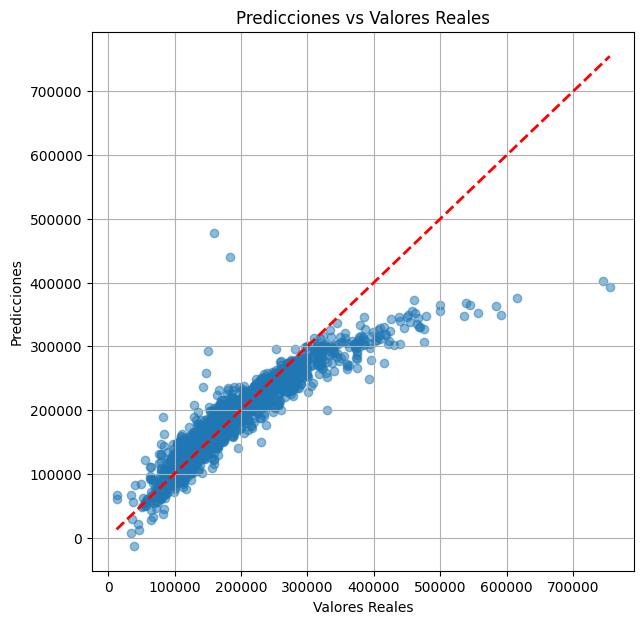

In [ ]:


# --- 1. Predicciones vs Valores Reales ---
plt.figure(figsize=(7,7))
plt.scatter(y_train, y_pred_svr, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales")
plt.grid(True)
plt.show()


## Comparación entre predicciones y valores reales

El gráfico de dispersión presentado muestra la relación entre los valores reales de la variable objetivo y las predicciones generadas por el modelo SVR.

La línea diagonal roja representa la **línea de referencia ideal**, es decir, el escenario en el que las predicciones coinciden perfectamente con los valores reales. Cuanto más cerca estén los puntos de esta línea, mejor será el desempeño predictivo del modelo.

### Análisis visual

- Se observa una **tendencia claramente positiva**, lo cual indica que el modelo es capaz de capturar correctamente la dirección general de la relación entre las variables.
- La mayoría de los puntos se agrupan en torno a la línea roja, especialmente en el rango medio del dominio de precios, lo cual es indicativo de una buena precisión en esa zona.
- En los extremos (valores muy bajos o muy altos), se percibe una **mayor dispersión** respecto a la línea de referencia. Esto sugiere que el modelo tiende a **subestimar precios altos** y a tener mayor error en los casos más extremos.

### Conclusión

Este gráfico confirma que el modelo SVR logra realizar predicciones razonablemente precisas en el rango central de los datos, aunque presenta ciertas limitaciones en los extremos. Aun así, la alineación general con la diagonal demuestra que el modelo tiene una capacidad predictiva adecuada para el problema en cuestión.


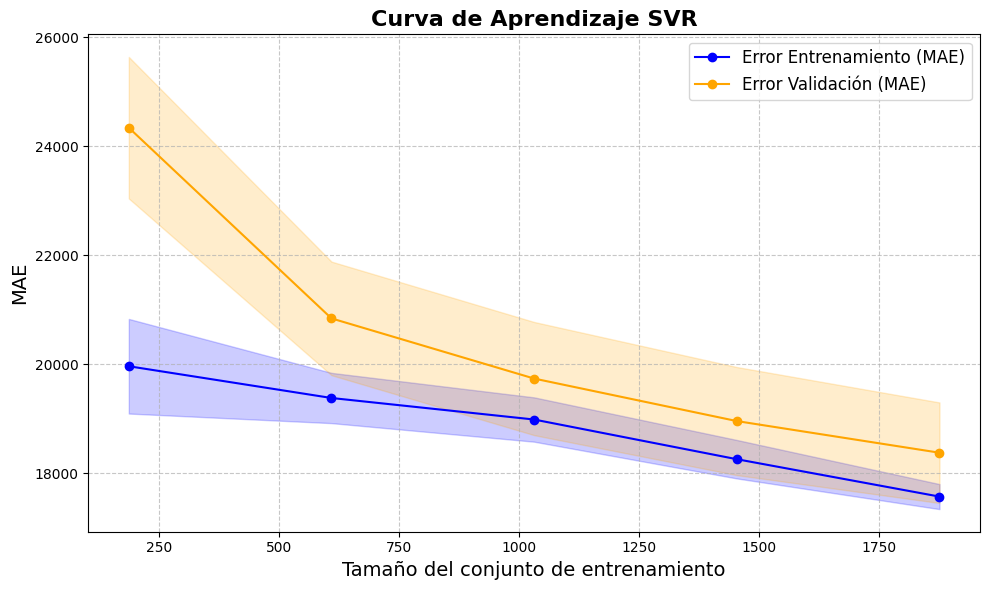

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    best_svr, X_train_scaled, y_train, cv=cv, scoring='neg_mean_absolute_error',
    n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5), verbose=0)

# Calcular medias y desviaciones estándar
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = -test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Error Entrenamiento (MAE)')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')

plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Error Validación (MAE)')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color='orange')

plt.title('Curva de Aprendizaje SVR', fontsize=16, fontweight='bold')
plt.xlabel('Tamaño del conjunto de entrenamiento', fontsize=14)
plt.ylabel('MAE', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## Curva de aprendizaje del modelo SVR

La curva de aprendizaje permite analizar cómo evoluciona el rendimiento del modelo a medida que se incrementa el tamaño del conjunto de entrenamiento. En este caso, se utilizó el **Error Absoluto Medio (MAE)** tanto para el conjunto de entrenamiento como para el de validación.

### Observaciones clave:

- **Ambas curvas (entrenamiento y validación) descienden de forma progresiva**, lo cual indica que el modelo mejora su capacidad de generalización a medida que dispone de más datos.
- La **brecha entre el error de entrenamiento y el de validación se reduce gradualmente**, aunque sigue existiendo una diferencia, lo que sugiere que el modelo aún puede beneficiarse de una mayor cantidad de datos o de ajustes en su complejidad.
- El hecho de que las curvas no se hayan estabilizado completamente sugiere que el modelo no ha alcanzado su punto de saturación y que existe potencial de mejora con más datos de entrenamiento.

### Conclusión de la curva:

El comportamiento observado es característico de un modelo **bien entrenado, sin sobreajuste evidente**, pero que aún no ha alcanzado su rendimiento máximo. Estos resultados refuerzan la validez del enfoque SVR para el problema analizado y apuntan a posibles mejoras mediante un mayor volumen de datos o ajustes finos en la regularización del modelo.

---

## Conclusiones generales

A lo largo de este cuaderno, se implementó y analizó un modelo de regresión basado en **Support Vector Machines (SVR)**, orientado a predecir valores continuos en un contexto realista. Se abordaron todas las etapas del flujo de trabajo: desde la optimización de hiperparámetros, validación cruzada, análisis de residuos y errores, hasta visualizaciones de desempeño.

### Principales hallazgos:

- El modelo SVR con kernel lineal mostró un **buen nivel de desempeño**, con métricas de error aceptables y estabilidad entre los folds.
- Los análisis estadísticos revelaron ciertas **limitaciones en la distribución de residuos**, como heterocedasticidad y falta de normalidad, aunque sin autocorrelación significativa.
- La comparación entre predicciones y valores reales reflejó una **tendencia clara y precisa**, especialmente en el rango medio del dominio.
- La curva de aprendizaje sugiere que **el modelo sigue mejorando** con más datos, lo que abre la puerta a futuras extensiones con un conjunto de entrenamiento ampliado.

### Consideraciones finales

Aunque el modelo ha demostrado resultados sólidos, la presencia de heterocedasticidad y errores elevados en los extremos podría explorarse más a fondo mediante:

- Transformaciones de la variable objetivo (por ejemplo, logarítmica).
- Métodos de regresión más robustos o modelos no lineales.
- Ingeniería de características adicionales.

Este trabajo constituye cimientos para aplicaciones prácticas de SVR en problemas de regresión, manteniendo un equilibrio entre rendimiento predictivo, interpretabilidad y robustez estadística.
